In [19]:
# usa el pip del kernel actual
%pip install -U pip setuptools wheel
%pip install -U scikit-learn
%pip install -U xlsxwriter
%pip install -U matplotlib
%pip install -U jinja2


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# === Celda 1: Config & utils (Inbound-aware, blended) ===
import pandas as pd, numpy as np, re
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import joblib

CONFIG = {
    "paths": {
        "tx_csv": "../../data/transacciones_cash_2025.csv",
        "export_segments_csv": "../../data/retail_behavior_segments.csv",
        "export_segment_profile_xlsx": "../../data/retail_segment_profiles.xlsx",
    },
    "period_start": "2025-03-01",
    "retail_label": "Retail",
    "focus_tx_type": "Cash",
    "directions": ["Outbound", "Inbound"], 

    # 1) Whales: por mediana mensual OUT (neutral a duración; útil para PGAV-OUT)
    "whales": {"method": "quantile", "q": 0.995, "floor_monthly_clp": 80_000_000},

    # 2) Mezcla IN→BLEND: cuánto pesa IN respecto de OUT
    "inbound_blend": {
        "alpha_intensity": 0.20,   # peso IN en intensidad mensual
        "beta_freq":       0.25,   # peso IN en frecuencia mensual
        "inbound_heavy_ratio": 0.70  # flag: IN/(IN+OUT) >= 70% -> inbound-heavy
    },

    # 3) Clustering (no-Whales): pesos de features blended
    "cluster": {
        "candidate_k": [3, 4],
        "random_state": 42,
        "min_cluster_share_pct": 3.0,           # evitar clusters diminutos
        "weights": {"log_intensity_blend": 1.0, "freq_blend": 0.5, "log_median_out_amount": 0.1}
    },

    # 4) Flags (modificadores de reglas; no cambian segmento)
    "spiky_flag": {"p95_over_median_tx": 6.0, "min_iqr_tx_clp": 150_000, "high_monthly_cv": 1.0}
}

def _to_datetime(s): return pd.to_datetime(s, errors="coerce")

def _to_numeric(series):
    if pd.api.types.is_numeric_dtype(series): return series
    return pd.to_numeric(pd.Series(series).astype(str).str.replace(r"[^\d\.\-]", "", regex=True), errors="coerce")

def _norm_col(c):
    c = str(c).replace("\ufeff","").strip()
    c = re.sub(r'^[\'"]|[\'"]$', '', c)     # comillas
    c = re.sub(r';+$','', c)               # ';' terminales
    c = re.sub(r'\s+','_', c)              # espacios -> '_'
    return c

Path(CONFIG["paths"]["persist_dir"]).mkdir(parents=True, exist_ok=True)


In [21]:
# === Celda 2: Carga, limpieza y filtrado ===
p = Path(CONFIG["paths"]["tx_csv"])
df = pd.read_csv(p, encoding="utf-8-sig")

# Normalizar encabezados y strings
df.columns = [_norm_col(c) for c in df.columns]
for col in df.select_dtypes(include="object").columns:
    df[col] = (df[col].astype(str)
                      .str.replace(r'^[\'"]|[\'"]$', '', regex=True)
                      .str.replace(r';+$', '', regex=True)
                      .str.strip())

# Parseos
df["tx_date_time"]   = _to_datetime(df["tx_date_time"])
df["tx_base_amount"] = _to_numeric(df["tx_base_amount"])

# Checks mínimos
required = ["tx_type","tx_direction","customer_sub_type","customer_id"]
missing = [c for c in required if c not in df.columns]
assert not missing, f"Faltan columnas {missing}. Presentes: {list(df.columns)}"

# Filtros
start_dt = pd.to_datetime(CONFIG["period_start"])
mask = (
    (df["tx_date_time"] >= start_dt) &
    (df["tx_type"].str.upper().eq(CONFIG["focus_tx_type"].upper())) &
    (df["customer_sub_type"].str.upper().eq(CONFIG["retail_label"].upper())) &
    (df["tx_direction"].isin(CONFIG["directions"]))
)
tx = df.loc[mask].copy()

# Llave cliente
tx = tx.dropna(subset=["customer_id"])
tx["customer_id"] = tx["customer_id"].astype(str).str.strip()

print("Filas filtradas:", len(tx), "| Clientes:", tx["customer_id"].nunique(),
      "| Direcciones:", tx["tx_direction"].value_counts().to_dict())


C:\Users\vinso\AppData\Local\Temp\ipykernel_20048\3543438491.py:3: DtypeWarning: Columns (70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(p, encoding="utf-8-sig")


Filas filtradas: 52192 | Clientes: 9351 | Direcciones: {'Outbound': 28703, 'Inbound': 23489}


In [22]:
# === Celda 3: Features por dirección (OUT/IN) y merge ===
def per_dir_ticket(tdf):
    g = tdf.groupby("customer_id", as_index=False)
    f = g.agg(
        median_amount=("tx_base_amount","median"),
        p95_amount=("tx_base_amount", lambda s: np.nanpercentile(s,95)),
        q75=("tx_base_amount", lambda s: np.nanpercentile(s,75)),
        q25=("tx_base_amount", lambda s: np.nanpercentile(s,25)),
        n_tx=("tx_id","count")
    )
    f["iqr_amount"] = (f["q75"] - f["q25"]).clip(lower=0)
    f["spiky_tx_ratio"] = f["p95_amount"] / f["median_amount"].replace(0,np.nan)
    f["spiky_tx_ratio"] = f["spiky_tx_ratio"].fillna(np.inf)
    f["log_median_amount"] = np.log1p(f["median_amount"])
    return f

def per_dir_monthly(tdf):
    tdf = tdf.copy()
    tdf["ym"] = tdf["tx_date_time"].dt.to_period("M")
    m = tdf.groupby(["customer_id","ym"], as_index=False).agg(
        month_total=("tx_base_amount","sum"),
        month_n_tx=("tx_id","count")
    )
    f = (m.groupby("customer_id", as_index=False)
           .agg(
               active_months=("ym","nunique"),
               tx_per_active_month=("month_n_tx","mean"),
               median_monthly=("month_total","median"),
               p75_monthly=("month_total", lambda s: np.nanpercentile(s,75)),
               monthly_cv=("month_total", lambda s: np.nanstd(s)/np.nanmean(s) if np.nanmean(s) else np.nan)
           ))
    f["log_median_monthly"] = np.log1p(f["median_monthly"])
    return f

def add_suffix_keep_key(df_, suffix, key="customer_id"):
    df_ = df_.copy()
    if df_.empty:
        return pd.DataFrame({key: pd.Series([], dtype=str)})
    cols = {c: f"{c}{suffix}" for c in df_.columns if c != key}
    return df_.rename(columns=cols)

# Split por dirección
tx_out = tx[tx["tx_direction"]=="Outbound"].copy()
tx_in  = tx[tx["tx_direction"]=="Inbound"].copy()

# Identidad y fechas
base = (tx.groupby("customer_id", as_index=False)
          .agg(customer_name=("customer_name","last"),
               first_tx=("tx_date_time","min"),
               last_tx=("tx_date_time","max")))

# OUT
f_out_tx  = add_suffix_keep_key(per_dir_ticket(tx_out),   "_out")
f_out_mon = add_suffix_keep_key(per_dir_monthly(tx_out),  "_out")
# IN
f_in_tx   = add_suffix_keep_key(per_dir_ticket(tx_in),    "_in")
f_in_mon  = add_suffix_keep_key(per_dir_monthly(tx_in),   "_in")

# Merge total
feat = (base
        .merge(f_out_tx,  on="customer_id", how="left")
        .merge(f_out_mon, on="customer_id", how="left")
        .merge(f_in_tx,   on="customer_id", how="left")
        .merge(f_in_mon,  on="customer_id", how="left"))

# Normalizar nombres "log_*" para consistencia
feat.rename(columns={
    "log_median_amount_out":   "log_median_out_amount",
    "log_median_monthly_out":  "log_median_monthly_out",
    "log_median_amount_in":    "log_median_in_amount",
    "log_median_monthly_in":   "log_median_monthly_in",
}, inplace=True)

# Completar NaN con 0 en métricas clave
for c in ["median_monthly_out","tx_per_active_month_out","median_amount_out",
          "median_monthly_in","tx_per_active_month_in","median_amount_in",
          "log_median_monthly_out","log_median_out_amount",
          "log_median_monthly_in","log_median_in_amount",
          "monthly_cv_out","monthly_cv_in"]:
    if c in feat.columns:
        feat[c] = pd.to_numeric(feat[c], errors="coerce").fillna(0)

print("feat.shape:", feat.shape)


feat.shape: (9351, 32)


In [23]:
# === Celda 4: BLEND (OUT + α·IN) y flag inbound-heavy ===
ib = CONFIG["inbound_blend"]

feat["intensity_blend"] = (
    pd.to_numeric(feat.get("median_monthly_out", 0), errors="coerce").fillna(0) +
    ib["alpha_intensity"] * pd.to_numeric(feat.get("median_monthly_in", 0), errors="coerce").fillna(0)
)

feat["freq_blend"] = (
    pd.to_numeric(feat.get("tx_per_active_month_out", 0), errors="coerce").fillna(0) +
    ib["beta_freq"] * pd.to_numeric(feat.get("tx_per_active_month_in", 0), errors="coerce").fillna(0)
)

feat["log_intensity_blend"] = np.log1p(feat["intensity_blend"])
if "log_median_out_amount" not in feat.columns:
    feat["log_median_out_amount"] = np.log1p(pd.to_numeric(feat.get("median_amount_out", 0), errors="coerce").fillna(0))

den = feat["median_monthly_out"] + feat["median_monthly_in"]
feat["inbound_share"] = np.where(den > 0, feat["median_monthly_in"]/den, 0.0)
feat["is_inbound_heavy"] = feat["inbound_share"] >= ib["inbound_heavy_ratio"]

feat[["intensity_blend","freq_blend","inbound_share","is_inbound_heavy"]].head()


,intensity_blend,freq_blend,inbound_share,is_inbound_heavy
0,4725640.0,1.375,0.761265,True
1,3591237.0,1.250,0.500731,False
2,314140.8,1.375,0.936680,True
3,1632849.0,1.000,0.000000,False
4,8962540.0,1.000,0.000000,False


In [ ]:
# === Celda 5: Búsqueda de umbral Whale (q) y peso IN (gamma) + elección de K por silhouette ===
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import joblib

# --- Config de búsqueda ---
q_grid     = [0.990, 0.9925, 0.995, 0.9975]      # percentiles candidatos
gamma_grid = [0.00, 0.10, 0.20, 0.30]            # peso de IN en el métrico Whale
min_share_wh, max_share_wh = 0.2, 2.0            # % mínimo/máximo razonable de whales
floor = CONFIG["whales"]["floor_monthly_clp"]     # piso absoluto (CLP)
cand_k = CONFIG["cluster"]["candidate_k"]         # p.ej. [3,4]
weights_map = CONFIG["cluster"]["weights"]        # {'log_intensity_blend':1.0, 'freq_blend':0.5, 'log_median_out_amount':0.1}

use_cols = ["log_intensity_blend", "freq_blend", "log_median_out_amount"]
weights  = np.array([weights_map[c] for c in use_cols], dtype=float)

def eval_setting(q, gamma):
    # Métrico Whale "blend": OUT + gamma*IN
    W = pd.to_numeric(feat.get("median_monthly_out", 0), errors="coerce").fillna(0) + \
        gamma * pd.to_numeric(feat.get("median_monthly_in", 0), errors="coerce").fillna(0)
    thr = max(W.quantile(q), floor)
    is_wh = W >= thr

    share = 100 * is_wh.mean()
    # descartar extremos por operación
    if not (min_share_wh <= share <= max_share_wh):
        return None

    remain = feat.loc[~is_wh].copy()
    if remain.empty or remain[use_cols].isna().all().all():
        return None

    X = remain[use_cols].fillna(0).to_numpy()
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X) * weights

    best = {"k": None, "sil": -np.inf, "ch": -np.inf, "db": np.inf, "labels": None, "model": None}
    for k in cand_k:
        if len(remain) <= k:
            continue
        km = KMeans(n_clusters=k, random_state=CONFIG["cluster"]["random_state"], n_init=10)
        labs = km.fit_predict(Xs)
        if len(np.unique(labs)) < 2:
            continue

        sil = silhouette_score(Xs, labs)
        ch  = calinski_harabasz_score(Xs, labs)
        db  = davies_bouldin_score(Xs, labs)

        # Evita clusters diminutos
        share_k = (pd.Series(labs).value_counts(normalize=True) * 100)
        if (share_k < CONFIG["cluster"]["min_cluster_share_pct"]).any():
            continue

        # criterio principal: silhouette; desempate por CH alto y DB bajo
        better = (sil > best["sil"]) or \
                 (np.isclose(sil, best["sil"]) and (ch > best["ch"] or (np.isclose(ch, best["ch"]) and db < best["db"])))
        if better:
            best.update({"k": k, "sil": sil, "ch": ch, "db": db, "labels": labs, "model": km})

    if best["labels"] is None:
        return None

    return {
        "q": q, "gamma": gamma, "threshold": float(thr),
        "whales": int(is_wh.sum()), "wh_share_pct": share,
        "best_k": best["k"], "silhouette": best["sil"], "calinski_h": best["ch"], "davies_b": best["db"],
        "is_whale_mask": is_wh, "scaler": scaler, "kmeans": best["model"]
    }

# --- Barrido de combinaciones ---
rows = []
for q in q_grid:
    for g in gamma_grid:
        res = eval_setting(q, g)
        if res is not None:
            rows.append(res)

assert rows, "No se encontró ninguna combinación (ajusta q_grid/gamma_grid o límites de share)."
grid = pd.DataFrame(rows).sort_values(["silhouette","calinski_h","wh_share_pct"], ascending=[False,False,True]).reset_index(drop=True)
display(grid[["q","gamma","threshold","whales","wh_share_pct","best_k","silhouette","calinski_h","davies_b"]].head(10))

# --- Elegimos la mejor por silhouette (con desempates ya aplicados arriba) ---
best = rows[0] if isinstance(rows, list) and rows and rows[0].get("silhouette") == grid.loc[0,"silhouette"] else None
if best is None:
    best = grid.iloc[0].to_dict()

print(f"Mejor configuración → q={best['q']}, gamma={best['gamma']} | umbral={best['threshold']:,.0f} CLP | "
      f"whales={best['whales']} ({best['wh_share_pct']:.2f}%) | K={best['best_k']} | silhouette={best['silhouette']:.3f}")

# --- Aplicamos a la segmentación final ---
feat["is_whale"] = best["is_whale_mask"]
remain = feat.loc[~feat["is_whale"]].copy()

# Etiquetas por K-means elegido
X = remain[use_cols].fillna(0).to_numpy()
Xs = best["scaler"].transform(X) * weights
labels = best["kmeans"].predict(Xs)
remain["cluster"] = labels

# Orden por OUT y desempate por BLEND
ord_df = (remain.groupby("cluster")
                .agg(med_out=("median_monthly_out","median"),
                     med_blend=("intensity_blend","median"))
                .sort_values(["med_out","med_blend"]))
order = ord_df.index.tolist()
rank_map = {cl: r for r, cl in enumerate(order)}
remain["cluster_rank"] = remain["cluster"].map(rank_map)
rank_to_label = {0:"Retail-Low", 1:"Retail-Mid", 2:"Retail-High", 3:"Retail-VHigh"}
remain["segment_label"] = remain["cluster_rank"].map(rank_to_label)

# Persistimos artefactos para scoring futuro
Path(CONFIG["paths"]["persist_dir"]).mkdir(parents=True, exist_ok=True)
joblib.dump(best["scaler"], Path(CONFIG["paths"]["persist_dir"])/"scaler_blend.pkl")
joblib.dump(best["kmeans"], Path(CONFIG["paths"]["persist_dir"])/"kmeans_blend.pkl")
joblib.dump(
    {"use_cols": use_cols, "weights": weights.tolist(),
     "whale_metric": "out + gamma*in", "q": float(best["q"]), "gamma": float(best["gamma"]),
     "whale_threshold": float(best["threshold"]), "floor": float(floor),
     "candidate_k": cand_k, "chosen_k": int(best["best_k"]),
     "silhouette": float(best["silhouette"])},
    Path(CONFIG["paths"]["persist_dir"])/"meta_blend.json"
)

# Fusionamos con feat y dejamos etiqueta final (whale > cluster > Mid)
feat["segment_label"] = pd.Series(pd.NA, index=feat.index, dtype="string")
feat.loc[feat["is_whale"], "segment_label"] = "Retail-Whale"
feat = feat.merge(remain[["customer_id","segment_label"]].rename(columns={"segment_label":"seg_rest"}),
                  on="customer_id", how="left")
feat["segment_label"] = feat["segment_label"].astype(object).combine_first(feat["seg_rest"]).fillna("Retail-Mid")
feat.drop(columns=["seg_rest"], inplace=True)


,q,gamma,threshold,whales,wh_share_pct,best_k,silhouette,calinski_h,davies_b
0,0.9900,0.0,1.923896e+08,94,1.005240,3,0.409346,9511.365927,0.806084
1,0.9900,0.3,2.347488e+08,94,1.005240,3,0.409331,9515.448542,0.805578
2,0.9900,0.1,2.068904e+08,94,1.005240,3,0.409239,9512.095123,0.802858
3,0.9900,0.2,2.227818e+08,94,1.005240,3,0.409209,9517.167076,0.805223
4,0.9925,0.1,2.448572e+08,71,0.759277,3,0.408763,9490.304594,0.806149
5,0.9925,0.0,2.370889e+08,71,0.759277,3,0.408730,9487.151140,0.805882
6,0.9925,0.3,2.793587e+08,71,0.759277,3,0.408716,9488.636007,0.806218
7,0.9925,0.2,2.696517e+08,71,0.759277,3,0.408709,9489.698558,0.806595
8,0.9950,0.3,3.619526e+08,47,0.502620,3,0.407930,9456.415811,0.806753
9,0.9950,0.1,3.011292e+08,47,0.502620,3,0.407877,9455.832183,0.807191


Mejor configuración → q=0.99, gamma=0.0 | umbral=192,389,583 CLP | whales=94 (1.01%) | K=3 | silhouette=0.409


In [25]:
# === Celda 6: Flags + etiqueta final + export & resumen ===
sp = CONFIG["spiky_flag"]

# Flags OUT/IN
feat["is_spiky_tx_out"] = (
    (feat.get("spiky_tx_ratio_out", np.nan) >= sp["p95_over_median_tx"]) &
    (feat.get("iqr_amount_out", 0) >= sp["min_iqr_tx_clp"])
)
feat["is_spiky_tx_in"] = (
    (feat.get("spiky_tx_ratio_in", np.nan) >= sp["p95_over_median_tx"]) &
    (feat.get("iqr_amount_in", 0) >= sp["min_iqr_tx_clp"])
)
feat["is_spiky_monthly_out"] = feat.get("monthly_cv_out", 0) >= sp["high_monthly_cv"]
feat["is_spiky_monthly_in"]  = feat.get("monthly_cv_in",  0) >= sp["high_monthly_cv"]
feat["is_spiky"] = feat[["is_spiky_tx_out","is_spiky_tx_in","is_spiky_monthly_out","is_spiky_monthly_in"]].fillna(False).any(axis=1)

# Etiqueta final: Whale > cluster > Mid
feat["segment_label"] = pd.Series(pd.NA, index=feat.index, dtype="string")
feat.loc[feat["is_whale"], "segment_label"] = "Retail-Whale"
feat = feat.merge(remain[["customer_id","segment_label"]].rename(columns={"segment_label":"seg_rest"}),
                  on="customer_id", how="left")
feat["segment_label"] = feat["segment_label"].astype(object).combine_first(feat["seg_rest"])
feat["segment_label"] = feat["segment_label"].fillna("Retail-Mid")
feat = feat.drop(columns=["seg_rest"])

# Export CSV
export_cols = [
    "customer_id","customer_name","segment_label","is_whale","is_inbound_heavy","is_spiky",
    # OUT
    "median_monthly_out","tx_per_active_month_out","monthly_cv_out",
    "median_amount_out","p95_amount_out","iqr_amount_out",
    # IN
    "median_monthly_in","tx_per_active_month_in","monthly_cv_in",
    "median_amount_in","p95_amount_in","iqr_amount_in",
    # BLEND
    "intensity_blend","freq_blend","inbound_share",
    # Fechas
    "first_tx","last_tx"
]

# Resumen
summary = (
    feat.groupby("segment_label", dropna=False)
        .agg(
            clients=("customer_id","nunique"),
            share_clients=("customer_id", lambda s: 100*s.nunique()/feat["customer_id"].nunique()),
            med_monthly_out=("median_monthly_out","median"),
            med_tx_month_out=("tx_per_active_month_out","median"),
            med_monthly_in=("median_monthly_in","median"),
            med_tx_month_in=("tx_per_active_month_in","median"),
            med_intensity_blend=("intensity_blend","median"),
            med_freq_blend=("freq_blend","median"),
            spiky_share=("is_spiky", lambda s: 100*s.mean())
        )
        .sort_values(["med_monthly_out","med_intensity_blend"])
)
summary


,clients,share_clients,med_monthly_out,med_tx_month_out,med_monthly_in,med_tx_month_in,med_intensity_blend,med_freq_blend,spiky_share
segment_label,,,,,,,,,
Retail-Low,1377,14.725698,0.0,0.0,58691.0,1.0,36000.0,0.250000,9.222948
Retail-Mid,4245,45.396214,721717.0,1.0,3521.0,1.0,1100000.0,1.000000,13.191991
Retail-High,3635,38.872848,8500000.0,1.5,1975000.0,1.0,10467650.0,1.666667,17.936726
Retail-Whale,94,1.005240,285229178.0,2.0,103119773.0,1.0,322977477.5,2.125000,25.531915


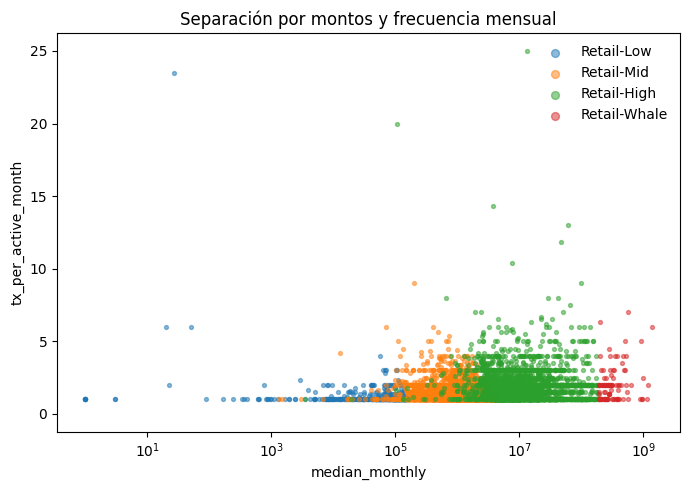

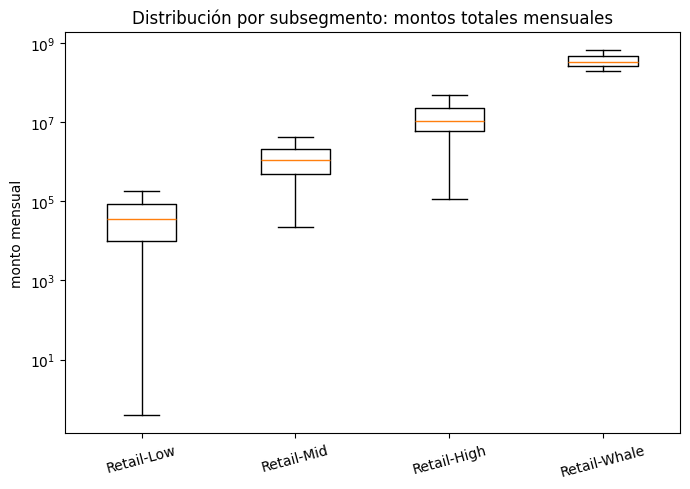

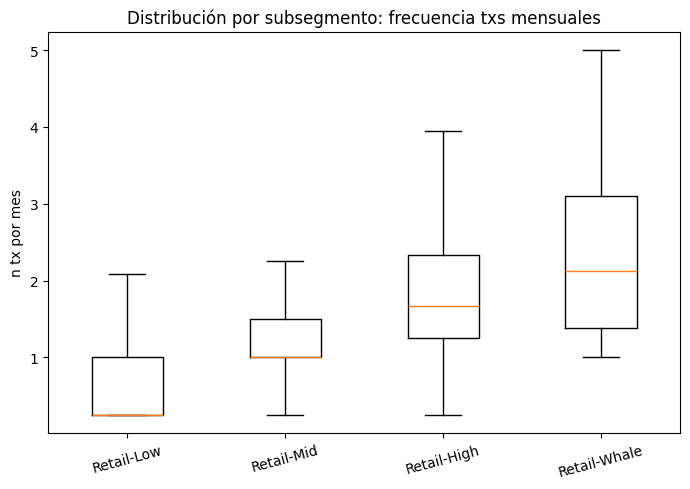

In [27]:
# === Celda 7: Visuales ===
import matplotlib.pyplot as plt

label_order = ["Retail-Low","Retail-Mid","Retail-High","Retail-Whale"]
feat["segment_label"] = pd.Categorical(feat["segment_label"], categories=label_order, ordered=True)

# 1) OUT: intensidad vs frecuencia
plt.figure(figsize=(7,5))
for lab in feat["segment_label"].cat.categories:
    d = feat[feat["segment_label"] == lab]
    if len(d)==0: continue
    plt.scatter(d["median_monthly_out"], d["tx_per_active_month_out"], s=8, alpha=0.5, label=lab)
plt.xscale("log"); plt.xlabel("median_monthly"); plt.ylabel("tx_per_active_month")
plt.title("Separación por montos y frecuencia mensual")
plt.legend(markerscale=2, frameon=False); plt.tight_layout(); plt.show()


# 3) Boxplots de intensidad BLEND y frecuencia BLEND
plt.figure(figsize=(7,5))
data_int = [feat.loc[feat["segment_label"]==lab, "intensity_blend"] for lab in label_order]
plt.boxplot(data_int, showfliers=False); plt.yscale("log")
plt.xticks(range(1,len(label_order)+1), label_order, rotation=15)
plt.ylabel("monto mensual"); plt.title("Distribución por subsegmento: montos totales mensuales")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
data_frq = [feat.loc[feat["segment_label"]==lab, "freq_blend"] for lab in label_order]
plt.boxplot(data_frq, showfliers=False)
plt.xticks(range(1,len(label_order)+1), label_order, rotation=15)
plt.ylabel("n tx por mes"); plt.title("Distribución por subsegmento: frecuencia txs mensuales")
plt.tight_layout(); plt.show()


Media y Mediana de Retail actual vs propuesto

In [ ]:
# === Comparativa con PROMEDIOS y MEDIANAS (misma estructura) ===
import numpy as np, pandas as pd
from pathlib import Path

def tmean(a, trim=0.05):
    s = pd.to_numeric(a, errors="coerce").dropna().values
    if s.size == 0: return 0.0
    s.sort(); k = int(np.floor(trim * s.size))
    return float(np.mean(s[k: s.size - k])) if k*2 < s.size else float(np.mean(s))

def mean_nonzero(a):
    s = pd.to_numeric(a, errors="coerce"); s = s[s > 0]
    return float(s.mean()) if len(s) else 0.0

def pct_true(s): 
    return float(100 * pd.Series(s).fillna(False).mean())

# ---------- PROMEDIOS ----------
def build_summary_mean(df, label_col="segment_label", trim=0.05):
    d = df.copy()
    d["out_active"] = pd.to_numeric(d.get("median_monthly_out", 0), errors="coerce").fillna(0) > 0
    d["in_active"]  = pd.to_numeric(d.get("median_monthly_in", 0),  errors="coerce").fillna(0) > 0
    g = d.groupby(label_col, dropna=False)
    return g.agg(
        clients=("customer_id", "nunique"),
        share_clients=("customer_id", lambda s: 100*s.nunique()/d["customer_id"].nunique()),
        mean_monthly_out=("median_monthly_out", "mean"),
        mean_tx_month_out=("tx_per_active_month_out", "mean"),
        mean_monthly_in=("median_monthly_in", "mean"),
        mean_tx_month_in=("tx_per_active_month_in", "mean"),
    )

# ---------- MEDIANAS (MISMAS COLUMNAS PERO CON PREFIX 'median_') ----------
def build_summary_median(df, label_col="segment_label"):
    d = df.copy()
    g = d.groupby(label_col, dropna=False)
    return g.agg(
        clients=("customer_id", "nunique"),
        share_clients=("customer_id", lambda s: 100*s.nunique()/d["customer_id"].nunique()),
        median_monthly_out=("median_monthly_out", "median"),
        median_tx_month_out=("tx_per_active_month_out", "median"),
        median_monthly_in=("median_monthly_in", "median"),
        median_tx_month_in=("tx_per_active_month_in", "median"),
    )

# 1) Subsegmentos
subsegments_mean   = build_summary_mean(feat)
subsegments_median = build_summary_median(feat)

# 2) Retail-ALL (antes)
all_df = feat.copy()
all_df["segment_all"] = "Retail-ALL"
retail_all_mean   = build_summary_mean(all_df,   label_col="segment_all")
retail_all_median = build_summary_median(all_df, label_col="segment_all")

# 3) Comparaciones (ALL + subsegmentos)
comparison_mean = pd.concat(
    [retail_all_mean.rename_axis("segment_label"), subsegments_mean], axis=0
)
comparison_median = pd.concat(
    [retail_all_median.rename_axis("segment_label"), subsegments_median], axis=0
)

# Orden de filas
order = ["Retail-ALL","Retail-Low","Retail-Mid","Retail-High","Retail-Whale"]
comparison_mean   = comparison_mean.reindex([i for i in order if i in comparison_mean.index])
comparison_median = comparison_median.reindex([i for i in order if i in comparison_median.index])

# 4) Export a Excel (mismo workbook, hojas nuevas)
xlsx = Path(CONFIG["paths"]["export_segment_profile_xlsx"])
with pd.ExcelWriter(xlsx, engine="xlsxwriter") as xlw:
    subsegments_mean.to_excel(xlw,   sheet_name="subsegments_mean")
    retail_all_mean.to_excel(xlw,    sheet_name="retail_all_mean")
    comparison_mean.to_excel(xlw,    sheet_name="comparison_mean")
    subsegments_median.to_excel(xlw, sheet_name="subsegments_median")
    retail_all_median.to_excel(xlw,  sheet_name="retail_all_median")
    comparison_median.to_excel(xlw,  sheet_name="comparison_median")

C:\Users\vinso\AppData\Local\Temp\ipykernel_6984\2519458457.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = d.groupby(label_col, dropna=False)
C:\Users\vinso\AppData\Local\Temp\ipykernel_6984\2519458457.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = d.groupby(label_col, dropna=False)


In [ ]:
# === Formato bonito en el NOTEBOOK (sin notación científica, con miles) ===
money_cols_mean   = ["mean_monthly_out","mean_monthly_in"]
freq_cols_mean    = ["mean_tx_month_out","mean_tx_month_in"]

money_cols_median = ["median_monthly_out","median_monthly_in"]
freq_cols_median  = ["median_tx_month_out","median_tx_month_in"]

fmt_mean = {
    **{c: "{:,.1f}" for c in money_cols_mean},        # 6,000,000.0
    **{c: "{:,.1f}" for c in freq_cols_mean},         # 1.0
    "clients": "{:,.0f}",
    "share_clients": "{:,.2f}"                         # si quieres: "{:,.2f}%"
}
fmt_median = {
    **{c: "{:,.1f}" for c in money_cols_median},
    **{c: "{:,.1f}" for c in freq_cols_median},
    "clients": "{:,.0f}",
    "share_clients": "{:,.2f}"
}

display(comparison_mean.style.format(fmt_mean, na_rep="—"))
display(comparison_median.style.format(fmt_median, na_rep="—"))


,clients,share_clients,mean_monthly_out,mean_tx_month_out,mean_monthly_in,mean_tx_month_in
segment_label,,,,,,
Retail-ALL,"9,351",100.00,"11,407,638.5",1.2,"12,753,041.4",0.9
Retail-Low,"1,377",14.73,"19,918.6",0.4,"158,039.8",0.9
Retail-Mid,"4,245",45.40,"1,037,923.9",1.0,"1,923,885.0",0.7
Retail-High,"3,635",38.87,"18,478,287.5",1.7,"22,589,028.9",1.0
Retail-Whale,94,1.01,"373,094,014.7",2.1,"305,936,783.8",1.4


,clients,share_clients,median_monthly_out,median_tx_month_out,median_monthly_in,median_tx_month_in
segment_label,,,,,,
Retail-ALL,"9,351",100.00,"1,501,578.0",1.0,"108,000.0",1.0
Retail-Low,"1,377",14.73,0.0,0.0,"58,691.0",1.0
Retail-Mid,"4,245",45.40,"721,717.0",1.0,"3,521.0",1.0
Retail-High,"3,635",38.87,"8,500,000.0",1.5,"1,975,000.0",1.0
Retail-Whale,94,1.01,"285,229,178.0",2.0,"103,119,773.0",1.0
